# Baseline Predictor for 15 Events Data

In this experiment, we build baseline on RF, SVR and LSTM on the indycar dataset.


In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import models, layers
import time
from sklearn.preprocessing import MinMaxScaler
# to use only one GPU.
# use this on r-001
# otherwise comment
import os
os.environ["CUDA_VISIBLE_DEVICES"]="7"


Using TensorFlow backend.


## Load Data

In [2]:
def plot_examples(X,y,ypreds=None,nm_ypreds=None):
    fig = plt.figure(figsize=(16,10))
    fig.subplots_adjust(hspace = 0.32,wspace = 0.15)
    count = 1
    n_ts = X.shape[0]
    num_per_row = 2 if n_ts > 2 else 1
    for irow in range(n_ts):
        ax = fig.add_subplot(int(n_ts+num_per_row -1)/num_per_row,num_per_row,count)
        #ax.set_ylim(-0.5,0.5)
        ax.plot(X[irow,:,0],"--",label="x1")
        ax.plot(y[irow,:,:],marker='.',label="y",linewidth=3,alpha = 0.5)
        ax.set_title("{:}th time series sample".format(irow))
        if ypreds is not None:
            for ypred,nm in zip(ypreds,nm_ypreds):
                ax.plot(ypred[irow,:,:],marker='.',label=nm)   
        count += 1
    plt.legend()
    plt.show()
    if ypreds is not None:
        for y_pred, nm_ypred in zip(ypreds,nm_ypreds):
            loss = np.mean( (y_pred[:,D:,:].flatten() - y[:,D:,:].flatten())**2)
            print("The final validation loss of {} is {:7.6f}".format(
                nm_ypred,loss))


In [3]:
# load multiple datasets
def load_data(datalist):
    #add 
    db = []
    lens = []
    for id, f in enumerate(datalist):
        data = pd.read_csv(f)
        data['dbid'] = id + 1
        db.append(data)
        
        carNumber = len(set(data.car_number))
        lens.append(carNumber)
        print('load %s, len=%d'%(f, data.shape[0]))
        
    
    alldata = None
    for d in db:
        #update car_number with the dbid
        d['car_number'] += d['dbid'] * 1000
        if alldata is None:
            alldata = d
        else:
            alldata = alldata.append(d)
    
    #scaler
    scaler = MinMaxScaler()
    alldata[['rank_diff', 'time_diff']] = scaler.fit_transform(alldata[['rank_diff', 'time_diff']])
    
    return scaler, alldata, lens

def generate_data(dataset, D= 1, target='rank'):
    # dataset with multiple events, car_number is encoded with event id
    # T is the max len
    
    carNumber = len(set(dataset.car_number))
    T = 0
    for car, group in dataset.groupby('car_number'):
        T = max(T, group.shape[0])
    print('carNumber = %d, max T =%d'%(carNumber, T))
    
    #variable len of time series
    x_train , y_train = [], []
    for car, group in dataset.groupby('car_number'):
        x = list(group.time_diff)
    
        if target == 'rank':
            y = list(group.rank_diff)
        elif target =='time':
            y = list(group.time_diff)
        else:
            print('error in target setting as', target)
            return None

        #get train/label
        retlen = len(x) - D
        if retlen <=0 :
            print('error with record, too short, car = %d, len=%d'%(car,len(x)))
            continue
        
        #output
        x_train.append(x[:retlen])
        y_train.append(y[D:])
        
    if len(x_train) != carNumber:
        print('error in carNumber')
        return x_train, y_train, x
    
    #convert to np array
    X = np.zeros((carNumber, T-D, 1))
    Y = np.zeros((carNumber, T-D, 1))
    W = np.zeros((carNumber, T-D))
    for car in range(carNumber):
        reclen = len(x_train[car])
        X[car, :reclen, 0] = np.array(x_train[car])
        Y[car, :reclen, 0] = np.array(y_train[car])        
        W[car, :reclen] = 1
        
    return X, Y, W

def read_list(listfile):
    datalist = []
    with open(listfile, 'r') as inf:
        for l in inf:
            datalist.append(l.strip())
    return datalist

### Load data and Initialization

In [4]:
# predict D lap in the future
D = 5 
# hidden utnits for LSTM
hunits = 16

In [5]:
#datalist = ['2017-all_completed_laps_diff.csv','2018-all_completed_laps_diff.csv' ]

#datalist = read_list('train_all.list')
datalist = read_list('train_completed.list')
scaler, dataset, dblens = load_data(datalist)

dataset.info(verbose=True)
print('dataset shape', dataset.shape)

load data/Barber-2018-completed_laps_diff.csv, len=797
load data/Gateway-2018-completed_laps_diff.csv, len=1992
load data/Indy500-2017-completed_laps_diff.csv, len=3216
load data/IndyGP-2018-completed_laps_diff.csv, len=1806
load data/Iowa-2018-completed_laps_diff.csv, len=1505
load data/LongBeach-2018-completed_laps_diff.csv, len=1204
load data/Mid-Ohio-2018-completed_laps_diff.csv, len=1274
load data/Phoenix-2018-completed_laps_diff.csv, len=2761
load data/Pocono-2018-completed_laps_diff.csv, len=804
load data/Portland-2018-completed_laps_diff.csv, len=1907
load data/RoadAmerica-2018-completed_laps_diff.csv, len=1008
load data/StPete-2018-completed_laps_diff.csv, len=1554
load data/Texas-2018-completed_laps_diff.csv, len=2241
load data/Toronto-2018-completed_laps_diff.csv, len=1290
load data/Indy500-2018-completed_laps_diff.csv, len=3618
<class 'pandas.core.frame.DataFrame'>
Int64Index: 26977 entries, 0 to 3617
Data columns (total 8 columns):
Unnamed: 0        26977 non-null int64
ca

In [6]:
# generate train/test dataset

# post-padding with 0
X, y, w = generate_data(dataset, D=D, target='time')

total = np.sum(dblens)
ntrain = np.sum(dblens[:-1])
nval = int(dblens[-1] / 2)
print('train=%d, val=%d, test=%d'%(ntrain, nval, total-ntrain-nval))

X_train, X_val, X_test = X[:ntrain], X[ntrain:ntrain + nval], X[ntrain + nval:]
y_train, y_val, y_test = y[:ntrain], y[ntrain:ntrain + nval], y[ntrain + nval:]
#weights
w_train, w_val, w_test = w[:ntrain], w[ntrain:ntrain + nval], w[ntrain+nval:]
print('train shape:', X_train.shape)

carNumber = 200, max T =301
train=182, val=9, test=9
train shape: (182, 296, 1)


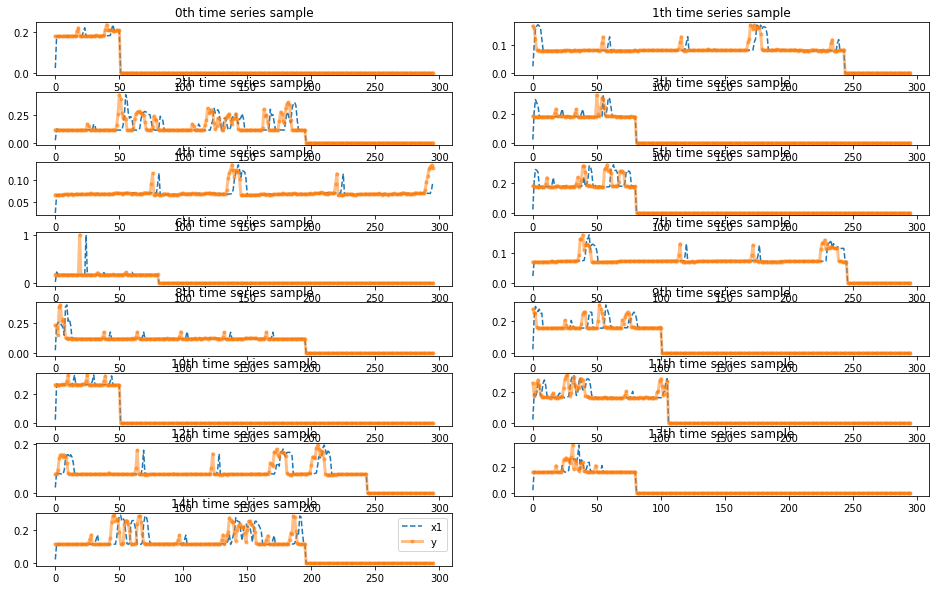

In [7]:
firstcar = np.cumsum(dblens)
idx = [0]
idx.extend(list(firstcar)[:-1])
plot_examples(X[idx],y[idx],ypreds=None,nm_ypreds=None)
#plot_examples(X[:10],y[:10],ypreds=None,nm_ypreds=None)

## Define model

In [8]:
#
# https://fairyonice.github.io/Stateful-LSTM-model-training-in-Keras.html
#
def define_model(len_ts,
                 hidden_neurons = 10,
                 nfeature=1,
                 batch_size=None,
                 stateful=False):
    in_out_neurons = 1
    
    inp = layers.Input(batch_shape= (batch_size, len_ts, nfeature),
                       name="input")  

    rnn = layers.LSTM(hidden_neurons, 
                    return_sequences=True,
                    stateful=stateful,
                    name="RNN")(inp)

    dens = layers.TimeDistributed(layers.Dense(in_out_neurons,name="dense"))(rnn)
    model = models.Model(inputs=[inp],outputs=[dens])
    
    #model.compile(loss="mean_squared_error",
    #              sample_weight_mode="temporal",
    #              optimizer="rmsprop")
    
    model.compile(loss="mean_absolute_error",
                  sample_weight_mode="temporal",
                  optimizer="adam")
    
    return(model,(inp,rnn,dens))

In [9]:

model_stateless, _ = define_model(
                    hidden_neurons = hunits,
                    len_ts = X_train.shape[1])
model_stateless.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 296, 1)            0         
_________________________________________________________________
RNN (LSTM)                   (None, 296, 16)           1152      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 296, 1)            17        
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


### train for 500 epochs


In [10]:
start = time.time()
history = model_stateless.fit(X_train,y_train,
                             batch_size=16,
                             shuffle=True,
                             epochs=500,
                             verbose=2,
                             sample_weight=w_train,
                             validation_data=(X_val,y_val,w_val))
end = time.time()
print("Time Took :{:3.2f} min".format( (end-start)/60 ))


Train on 182 samples, validate on 9 samples
Epoch 1/500
 - 3s - loss: 0.0442 - val_loss: 0.0271
Epoch 2/500
 - 3s - loss: 0.0200 - val_loss: 0.0341
Epoch 3/500
 - 3s - loss: 0.0190 - val_loss: 0.0223
Epoch 4/500
 - 3s - loss: 0.0179 - val_loss: 0.0224
Epoch 5/500
 - 3s - loss: 0.0166 - val_loss: 0.0243
Epoch 6/500
 - 3s - loss: 0.0156 - val_loss: 0.0232
Epoch 7/500
 - 3s - loss: 0.0146 - val_loss: 0.0221
Epoch 8/500
 - 3s - loss: 0.0136 - val_loss: 0.0221
Epoch 9/500
 - 3s - loss: 0.0126 - val_loss: 0.0227
Epoch 10/500
 - 3s - loss: 0.0116 - val_loss: 0.0230
Epoch 11/500
 - 3s - loss: 0.0113 - val_loss: 0.0229
Epoch 12/500
 - 3s - loss: 0.0111 - val_loss: 0.0226
Epoch 13/500
 - 3s - loss: 0.0110 - val_loss: 0.0224
Epoch 14/500
 - 3s - loss: 0.0109 - val_loss: 0.0225
Epoch 15/500
 - 3s - loss: 0.0108 - val_loss: 0.0222
Epoch 16/500
 - 3s - loss: 0.0107 - val_loss: 0.0223
Epoch 17/500
 - 3s - loss: 0.0106 - val_loss: 0.0221
Epoch 18/500
 - 3s - loss: 0.0106 - val_loss: 0.0223
Epoch 19/5

KeyboardInterrupt: 

In [ ]:
y_pred_stateless = model_stateless.predict(X_test)
plot_examples(X_test,y_test,ypreds=[y_pred_stateless],nm_ypreds=["y_pred stateless"])

### train for 2000 epochs
It is amazing to see the capacity of the model, which predicts the pikes of crashes ''accurately''.
However, the performance goes worse in the cases of pitstops. They are totally ignored.
Overfitting must occur here.
To verify that, let''s train on data of a different event, such as train on 2017 and then test on 2018. 
Another idea is to modify the loss funtion to emphysize on pitstops.



In [ ]:
start = time.time()
history = model_stateless.fit(X_train,y_train,
                             batch_size=32,
                             shuffle=True,
                             epochs=2000,
                             verbose=2,
                             sample_weight=w_train,
                             validation_data=(X_val,y_val,w_val))
end = time.time()
print("Time Took :{:3.2f} min".format( (end-start)/60 ))


In [ ]:
y_pred_stateless = model_stateless.predict(X_test)
plot_examples(X_test,y_test,ypreds=[y_pred_stateless],nm_ypreds=["y_pred stateless"])

In [ ]:
y_pred_stateless = model_stateless.predict(X_train)
plot_examples(X_train,y_train,ypreds=[y_pred_stateless],nm_ypreds=["y_pred stateless"])

### conclusion

Obviously, the model capture the crashes in 2017 but failed in predicting what happens in 2018.

As crashes are not ''predictable'', we would like to train a model to capture the pitstops rather than the bigger
spikes caused by the ''random'' crashes.

In the next step, let''s try to modify the loss function to suppress the effects of crashes and emphysize on 
pitstops. After all, the ranking are influenced more by pitstops.
